# Shooting and Time-Elimination Methods for Solving the Ramsey Model with Full or No Commitment

### Load Packages and Define the Initial Value Problem (IVP) Solver

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, ode
from scipy.special import roots_laguerre
import timeit

In [2]:
def ivp_solve(odefunc,y0,t0,tf,dt,r,backwards=False):
    tv, sol = [], []

    f = ode(odefunc).set_integrator('lsoda',with_jacobian=True)
    tic = timeit.default_timer()
    sol.append(y0)
    if backwards:
        f.set_initial_value(y0,tf).set_f_params(r).set_jac_params(r)
        tv.append(tf)
        dt = -1*dt
        while f.successful() and f.t > t0:
            f.integrate(f.t+dt)
            sol.append(f.y)
            tv.append(f.t)
        toc = timeit.default_timer()
        print('IVP run complete in {:4.2f} seconds.'.format(toc-tic))
    else:
        f.set_initial_value(y0,t0).set_f_params(r).set_jac_params(r)
        tv.append(t0)
        while f.successful() and f.t < tf:
            f.integrate(f.t+dt)
            sol.append(f.y)
            tv.append(f.t)
        toc = timeit.default_timer()
        print('IVP run complete in {:4.2f} seconds.'.format(toc-tic))

    return tv, sol

### Define the System of Equations and Relevant Parameters

###### Solve the nonlinear system of equations

Full Commitment:
\begin{align}
\dot{k} &= k^\alpha - \left(\delta + n + x\right)k - c\\
\dot{c} &= c\left(\alpha k^{\alpha - 1} - \left(\delta + x\right) - \left(\rho + be^{-\gamma t}\right) \right)
\end{align}

No Commitment:
\begin{align}
\dot{k} &= k^\alpha - \left(\delta + n + x\right)k - c\\
\dot{c} &= c\left(\alpha k^{\alpha - 1} - \left(\delta + x + \lambda\right) \right)
\end{align}

with $k(0) = k_0 = 0.25k^\ast_0$.

In [3]:
def Fode(t,y,r):
    # System of Equations
    # order for r: alpha, delta, xt, n, rho, b, gamma
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    return np.array([y[0]**alpha-(delta+xt+n)*y[0]-y[1],
            y[1]*(alpha*y[0]**(alpha-1)-(delta+xt)-(rho+b*np.exp(-gamma*t)))])

###### Jacobian of the System
$$J(k,c)=
\begin{bmatrix}
\alpha k^{\alpha-1}-\left(\delta+n+x\right) & -1\\
\alpha(\alpha-1)ck^{\alpha-2} & \alpha k^{\alpha - 1} - \left(\delta + x\right) - \left(\rho + be^{-\gamma t}\right)\\
\end{bmatrix}$$

In [4]:
def jac(t,y,r):
    # order for r: alpha, delta, xt, n, rho, b, gamma
    alpha, delta, xt, n, rho, b, gamma = r[0], r[1], r[2], r[3], r[4], r[5], r[6]
    return np.array([[alpha*y[0]**(alpha-1)-(delta+n+xt),-1],
            [y[1]*alpha*(alpha-1)*y[0]**(alpha-2),alpha*y[0]**(alpha-1)-(delta+xt)-(rho+b*np.exp(-gamma*t))]])

### Compute the Model Parameters

###### Integrand for $\lambda$ as defined in Barro
$$\lambda = \frac1{\int_0^\infty e^{-\left(\rho v+\phi(v)\right)}\,dv}$$
where $$\phi(v)=\frac{b}{\gamma}\left(1-e^{-\gamma v}\right)$$
but since Gauss-Laguerre quadrature is being used, write the integral as
$$e^{-\frac{b}{\gamma}}\int_0^\infty e^{\frac{b}{\gamma}e^{-\gamma v}}\,e^{-\rho v}dv$$ and the weigthing becomes $$e^{-x}\frac{dx}{\rho}$$ for the quadrature rule.

In [5]:
def g(x,b,gamma):
    return np.exp(-b/gamma)*np.exp((b/gamma)*np.exp(-gamma*x))

In [6]:
# Set the model parameters
alpha, delta, xt, n = 0.75, 0.05, 0.02, 0.01
#alpha, delta, xt, n = 0.33, 0.05, 0.02, 0.01
rho, b, gamma = 0.02, 0.5, 0.5
#rho, b, gamma = 0.02, 0.2, 0.5
#rho, b, gamma = 0.02, 0.1, 0.5
#----------------------------------------------------------------
# Compute the lambda integral using Gauss-Laguerre quadrature
#----------------------------------------------------------------
N = 100
x,w = roots_laguerre(N)
x /= (rho-n)
w /= (rho-n)
Omega = w.dot(g(x,b,gamma))
lam = 1/Omega+n
#----------------------------------------------------------------
# No Commitment
#----------------------------------------------------------------
kzed = (alpha/(delta + lam + xt))**(1/(1-alpha)) # No commitment
czed = kzed**alpha - (delta + n + xt)*kzed # No commitment
#----------------------------------------------------------------
# Full Commitment
#----------------------------------------------------------------
kinf = (alpha/(delta + rho + xt))**(1/(1-alpha)) # Commitment
cinf = kinf**alpha - (delta + n + xt)*kinf # Commitment
#----------------------------------------------------------------
# Equilibria under no-commitment
#----------------------------------------------------------------
eq = np.array([kzed,czed])
print('k* no commitment: {:4.4f}'.format(kzed))
print('c* no commitment: {:4.4f}'.format(czed))
print('k(0) = {:2.4f}'.format(0.25*kzed))
print('k* commitment: {:4.4f}'.format(kinf))
print('c* commitment: {:4.4f}'.format(cinf))
print('lambda = {:4.4f}'.format(lam))
#----------------------------------------------------------------
print('k relative percentage full to none: {:2.4f}'.format((kinf-kzed)/kzed))
print('c relative percentage full to none: {:2.4f}'.format((cinf-czed)/czed))

k* no commitment: 2456.8795
c* no commitment: 152.4195
k(0) = 614.2199
k* commitment: 4822.5309
c* commitment: 192.9012
lambda = 0.0365
k relative percentage full to none: 0.9629
c relative percentage full to none: 0.2656


### Solve the Full Commitment Case Using an Infinite Time-horizon Secant Shooting Method

In [7]:
# ****************************************************************************************
# Full Commitment
# ****************************************************************************************
# Store the model parameters
# order for r: alpha, delta, xt, n, rho, b, gamma
r = (alpha, delta, xt, n, rho, b, gamma)
# Set the starting conditions
k0 = 0.25*kzed
kstart = kinf

# Set the simulation parameters
# Remark: the model variables clearly asymptote by tf = 300 for Barro cases (1) -- (3)
# Remark: the model variables clearly asymptote by tf = 70 for Barro cases (4) -- (6)
# Remark: tf may need to be reset to a later or earlier time depending on the model parameters
t0, tf, dt = 0, 300, 3e-3
# Set the perturbation of cinf
eps = 5e-9
# Set the secant method parameters
tol, error, nits, MAXITS = 5e-9, 1, 0, 50

# Prime the algorithm with initial guess and one IVP solve
cu = cinf+eps
cl = cinf-eps
y0 = [kstart, cl]
tv, p = ivp_solve(Fode,y0,t0,tf,dt,r,backwards=True)
kl = p[-1][0]
# Start the while loop
while error > tol and nits < MAXITS:
    print('Iteration {:d}'.format(nits))
    # ***************************************************************
    # Evalute the function that will be zero at the left boundary
    # This block acts as the function for the secant method
    # ***************************************************************
    zl = kl-k0 # boundary evaluation
    y0 = [kstart, cu] # set initial condition
    tv, p = ivp_solve(Fode,y0,t0,tf,dt,r,backwards=True) # solve IVP
    ku = p[-1][0] # store left boundary value
    zu = ku-k0 # boundary evaluation
    # ***************************************************************
    # Store c_n and k_n to be c_{n-1} and k_{n-1} in the next iteration
    # these values get swapped below in **
    ctmp, ktmp = cu, ku
    # Compute the correction to c_n and use its absolute value as the error
    eta = zu*(cu-cl)/(zu-zl)
    # Store c_{n+1} using the secant method by overwriting c_n
    cu -= eta
    # Compute the error using the Cauchy-criterion for convergence
    error = np.fabs(eta)
    # ** Swap in c_{n-1} and k_{n-1}
    cl, kl = ctmp, ktmp
    nits += 1

print('-'*50)
print('Shooting Algorithm Complete in {:d} iterations with error {:2.4e}'.format(nits,error))

capl = np.array(p)[:,0]
cons = np.array(p)[:,1]
kinf0 = capl[-1]
cinf0 = cons[-1]
print('k_0 = {:2.7f}'.format(k0))
print('k(0) ~ {:2.7f}'.format(kinf0))
print('c(0) ~ {:2.7f}'.format(cinf0))

IVP run complete in 0.89 seconds.
Iteration 0
IVP run complete in 0.87 seconds.
Iteration 1
IVP run complete in 0.84 seconds.
Iteration 2
IVP run complete in 0.85 seconds.
Iteration 3
IVP run complete in 0.82 seconds.
Iteration 4
IVP run complete in 0.82 seconds.
Iteration 5
IVP run complete in 0.89 seconds.
Iteration 6
IVP run complete in 0.79 seconds.
Iteration 7
IVP run complete in 0.83 seconds.
Iteration 8
IVP run complete in 0.83 seconds.
Iteration 9
IVP run complete in 0.87 seconds.
--------------------------------------------------
Shooting Algorithm Complete in 10 iterations with error 6.0115e-12
k_0 = 614.2198780
k(0) ~ 614.2198780
c(0) ~ 77.4063660


### Display the Results

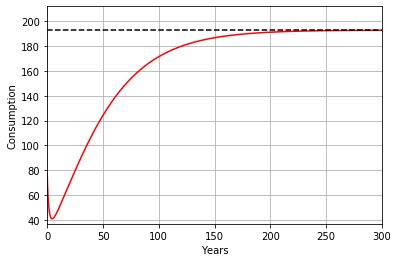

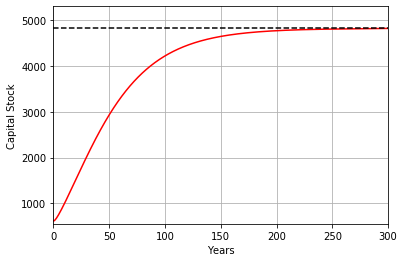

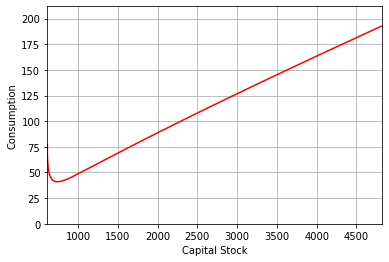

In [8]:
# Consumption
plt.figure()
plt.plot(tv,cons,'r',[t0,tf],[cinf,cinf],'k--')
plt.xlabel('Years')
plt.ylabel('Consumption')
plt.grid(b=True)
plt.axis([t0,tf,np.min(cons)*0.9,np.max(cons)*1.1])
# Capital
plt.figure()
plt.plot(tv,capl,'r',[t0,tf],[kinf,kinf],'k--')
plt.xlabel('Years')
plt.ylabel('Capital Stock')
plt.grid(b=True)
plt.axis([t0,tf,np.min(capl)*0.9,np.max(capl)*1.1])
# Policy Curve
plt.figure()
plt.plot(capl,cons,'r')
plt.xlabel('Capital Stock')
plt.ylabel('Consumption')
plt.grid(b=True)
plt.axis([np.min(capl),np.max(capl),np.min(cons)*0.0,np.max(cons)*1.1]);

### Solve the No Commitment Case Using the Time-elimination Method

In [9]:
def dc(k,c,r):
    alpha, delta, xt, n, lam = r[0], r[1], r[2], r[3], r[4]
    return c*(alpha*k**(alpha-1)-(delta+xt)-lam)/(k**alpha-(delta+n+xt)*k-c)

In [10]:
# ****************************************************************************************
# No commitment
# ****************************************************************************************
# order for r: alpha, delta, xt, n, lam, b, gamma
r = (alpha, delta, xt, n, lam, 0, 0)
# Set the starting conditions
eps = 1e-4
k0 = 0.25*kzed
kstart, kfinish, cstart = kzed, k0, czed-eps

In [11]:
dk = -2e-3
f = ode(dc).set_integrator('lsoda')
f.set_initial_value(cstart,kstart).set_f_params(r)
kv, sol = [], []

while f.successful() and f.t > k0:
    f.integrate(f.t+dk)
    sol.append(f.y[0])
    kv.append(f.t)
c00 = sol[-1]

print('k_0 = {:2.7f}'.format(k0))
print('k(0) ~ {:2.7f}'.format(k0))
print('c(0) ~ {:2.7f}'.format(c00))

k_0 = 614.2198780
k(0) ~ 614.2198780
c(0) ~ 43.8920491


###### Compute the relative percentage of full-commitment initial consumption to no-commitment initial consumption.

In [12]:
print('[c(0)_infty-c(0)_0]/c(0)_0 = {:2.3f}'.format((cinf0-c00)/c00))

[c(0)_infty-c(0)_0]/c(0)_0 = 0.764


### Linearized System

###### Notice that the Jacobian at the steady-state becomes

$$J(k,c)=
\begin{bmatrix}
\alpha k^{\alpha-1}-\left(\delta+n+x\right) & -1\\
\alpha(\alpha-1)ck^{\alpha-2} & 0\\
\end{bmatrix}$$

Find the eigenvalues and eigenvectors of this matrix to check the stability of the system centered at the steady-state.

In [13]:
# Use the Jacobian matrix defined above to solve the linearized system about an equilibrium
# and perform stability analysis by checking the eigenvalues of the matrix
r = (alpha, delta, xt, n, lam, 0, gamma)
J = jac(0,[kzed,czed],r)
print('Jacobian Matrix: \n{}'.format(J))
ew, ev = np.linalg.eig(J)
print('eigenvalues: {}'.format(ew))
print('eigenvectors in columns: \n{}'.format(np.dot(np.linalg.inv(ev),np.dot(J,ev))))

Jacobian Matrix: 
[[ 0.02652837 -1.        ]
 [-0.0016522   0.        ]]
eigenvalues: [ 0.05602089 -0.02949252]
eigenvectors in columns: 
[[ 5.60208942e-02  3.46944695e-18]
 [ 3.46944695e-18 -2.94925201e-02]]


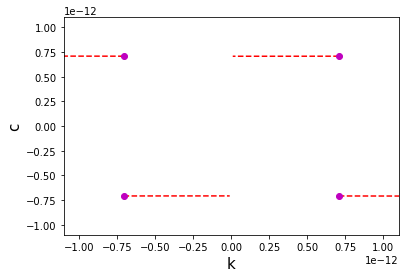

In [14]:
# Set the initial conditions, one in each quadrant
eps0 = 1e-12
t = np.linspace(0,1)
# Use the analytic solution to view the solutions for the various initial conditions
for th in np.linspace(np.pi/4,7*np.pi/4,4):
    y0 = np.array([eps0*np.cos(th),eps0*np.sin(th)])
    C = np.dot(np.linalg.inv(ev),y0)
    kbar = C[0]*ev[0,0]*np.exp(ew[0]*t)+C[1]*ev[0,1]*np.exp(ew[1]*t)
    cbar = C[0]*ev[1,0]*np.exp(ew[0]*t)+C[1]*ev[1,1]*np.exp(ew[1]*t)
    plt.plot(kbar,cbar,'r--',y0[0],y0[1],'mo')
# Display the solutions with initial values
plt.axis([-eps0*1.1, eps0*1.1, -eps0*1.1, eps0*1.1])
plt.xlabel('k',size=15)
plt.ylabel('c',size=15);